In [ ]:
#@title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License.

# Windowing -- _Tour of Beam_

Sometimes, we want to [aggregate](https://beam.apache.org/documentation/transforms/python/overview/#aggregation) data, like `GroupByKey` or `Combine`, only at certain intervals, like hourly or daily, instead of processing the entire `PCollection` of data only once.

We might want to emit a [moving average](https://en.wikipedia.org/wiki/Moving_average) as we're processing data.

Maybe we want to analyze the user experience for a certain task in a web app, it would be nice to get the app events by sessions of activity.

Or we could be running a streaming pipeline, and there is no end to the data, so how can we aggregate data?

_Windows_ in Beam allow us to process only certain data intervals at a time.
In this notebook, we go through different ways of windowing our pipeline.

Lets begin by installing `apache-beam`.

In [ ]:
# Install apache-beam with pip.
!pip install --quiet apache-beam

First, lets define some helper functions to simplify the rest of the examples.

We have a transform to help us analyze an element alongside its window information, and we have another transform to help us analyze how many elements landed into each window.
We use a custom [`DoFn`](https://beam.apache.org/documentation/transforms/python/elementwise/pardo)
to access that information.

You don't need to understand these, you just need to know they exist 🙂.

In [1]:
import apache_beam as beam

def human_readable_window(window) -> str:
  """Formats a window object into a human readable string."""
  if isinstance(window, beam.window.GlobalWindow):
    return str(window)
  return f'{window.start.to_utc_datetime()} - {window.end.to_utc_datetime()}'

class PrintElementInfo(beam.DoFn):
  """Prints an element with its Window information."""
  def process(self, element, timestamp=beam.DoFn.TimestampParam, window=beam.DoFn.WindowParam):
    print(f'[{human_readable_window(window)}] {timestamp.to_utc_datetime()} -- {element}')
    yield element

@beam.ptransform_fn
def PrintWindowInfo(pcollection):
  """Prints the Window information with how many elements landed in that window."""
  class PrintCountsInfo(beam.DoFn):
    def process(self, num_elements, window=beam.DoFn.WindowParam):
      print(f'>> Window [{human_readable_window(window)}] has {num_elements} elements')
      yield num_elements

  return (
      pcollection
      | 'Count elements per window' >> beam.combiners.Count.Globally().without_defaults()
      | 'Print counts info' >> beam.ParDo(PrintCountsInfo())
  )

Now lets create some data to use in the examples.

Windows define data intervals based on time, so we need to tell Apache Beam a timestamp for each element.

We define a `PTransform` for convenience, so we can attach the timestamps automatically.

Apache Beam requires us to provide the timestamp as [Unix time](https://en.wikipedia.org/wiki/Unix_time), which is a way to represent a date and time as the number of seconds since January 1st, 1970.

For our data, lets analyze some events about the seasons and moon phases for the year 2021, which might be [useful for a gardening project](https://www.almanac.com/content/planting-by-the-moon).

To attach timestamps to each element, we can `Map` each element and return a [`TimestmpedValue`](https://beam.apache.org/documentation/transforms/python/elementwise/withtimestamps/).

In [3]:
import time
from apache_beam.options.pipeline_options import PipelineOptions

def to_unix_time(time_str: str, time_format='%Y-%m-%d %H:%M:%S') -> int:
  """Converts a time string into Unix time."""
  time_tuple = time.strptime(time_str, time_format)
  return int(time.mktime(time_tuple))

@beam.ptransform_fn
@beam.typehints.with_input_types(beam.pvalue.PBegin)
@beam.typehints.with_output_types(beam.window.TimestampedValue)
def AstronomicalEvents(pipeline):
  return (
      pipeline
      | 'Create data' >> beam.Create([
          ('2021-03-20 03:37:00', 'March Equinox 2021'),
          ('2021-04-26 22:31:00', 'Super full moon'),
          ('2021-05-11 13:59:00', 'Micro new moon'),
          ('2021-05-26 06:13:00', 'Super full moon, total lunar eclipse'),
          ('2021-06-20 22:32:00', 'June Solstice 2021'),
          ('2021-08-22 07:01:00', 'Blue moon'),
          ('2021-09-22 14:21:00', 'September Equinox 2021'),
          ('2021-11-04 15:14:00', 'Super new moon'),
          ('2021-11-19 02:57:00', 'Micro full moon, partial lunar eclipse'),
          ('2021-12-04 01:43:00', 'Super new moon'),
          ('2021-12-18 10:35:00', 'Micro full moon'),
          ('2021-12-21 09:59:00', 'December Solstice 2021'),
      ])
      | 'With timestamps' >> beam.MapTuple(
          lambda timestamp, element:
              beam.window.TimestampedValue(element, to_unix_time(timestamp))
      )
  )

# Lets see how the data looks like.
beam_options = PipelineOptions(flags=[], type_check_additional='all')
with beam.Pipeline(options=beam_options) as pipeline:
  (
      pipeline
      | 'Astronomical events' >> AstronomicalEvents()
      | 'Print element' >> beam.Map(print)
  )

March Equinox 2021
Super full moon
Micro new moon
Super full moon, total lunar eclipse
June Solstice 2021
Blue moon
September Equinox 2021
December Solstice 2021
Super new moon
Micro full moon, partial lunar eclipse
Super new moon
Micro full moon


> ℹ️ After running this, it looks like the timestamps disappeared!
> They're actually still _implicitly_ part of the element, just like the windowing information.
> If we need to access it, we can do so via a custom [`DoFn`](https://beam.apache.org/documentation/transforms/python/elementwise/pardo).
> Aggregation transforms use each element's timestamp along with the windowing we specified to create windows of elements.

# Global window

All pipelines use the [`GlobalWindow`](https://beam.apache.org/releases/pydoc/current/apache_beam.transforms.window.html#apache_beam.transforms.window.GlobalWindow) by default.
This is a single window that covers the entire `PCollection`.

In many cases, especially for batch pipelines, this is what we want since we want to analyze all the data that we have.

> ℹ️ `GlobalWindow` is not very useful in a streaming pipeline unless you only need element-wise transforms.
> Aggregations, like `GroupByKey` and `Combine`, need to process the entire window, but a streaming pipeline has no end, so they would never finish.

In [4]:
import apache_beam as beam

# All elements fall into the GlobalWindow by default.
with beam.Pipeline() as pipeline:
  (
      pipeline
      | 'Astrolonomical events' >> AstronomicalEvents()
      | 'Print element info' >> beam.ParDo(PrintElementInfo())
      | 'Print window info' >> PrintWindowInfo()
  )

[GlobalWindow] 2021-03-20 03:37:00 -- March Equinox 2021
[GlobalWindow] 2021-04-26 22:31:00 -- Super full moon
[GlobalWindow] 2021-05-11 13:59:00 -- Micro new moon
[GlobalWindow] 2021-05-26 06:13:00 -- Super full moon, total lunar eclipse
[GlobalWindow] 2021-06-20 22:32:00 -- June Solstice 2021
[GlobalWindow] 2021-08-22 07:01:00 -- Blue moon
[GlobalWindow] 2021-09-22 14:21:00 -- September Equinox 2021
[GlobalWindow] 2021-12-21 09:59:00 -- December Solstice 2021
[GlobalWindow] 2021-11-04 15:14:00 -- Super new moon
[GlobalWindow] 2021-11-19 02:57:00 -- Micro full moon, partial lunar eclipse
[GlobalWindow] 2021-12-04 01:43:00 -- Super new moon
[GlobalWindow] 2021-12-18 10:35:00 -- Micro full moon
>> Window [GlobalWindow] has 12 elements


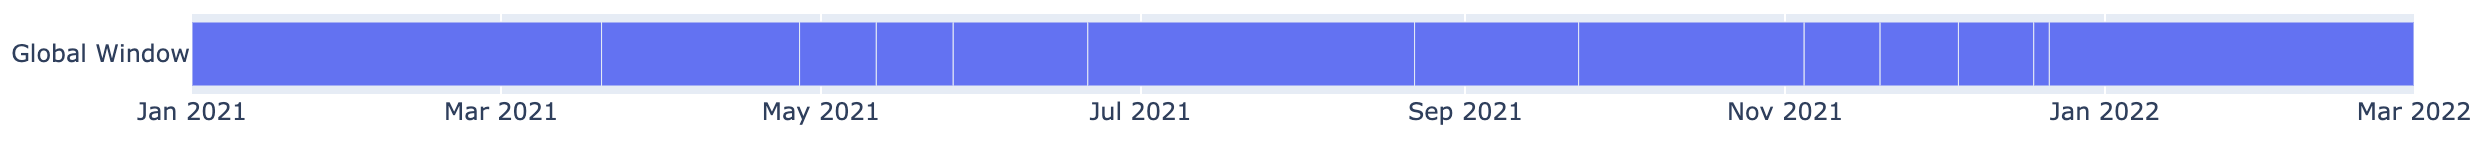

# Fixed time windows

If we want to analyze our data hourly, daily, monthly, etc. We might want to create evenly spaced intervals.

[`FixedWindows`](https://beam.apache.org/releases/pydoc/current/apache_beam.transforms.window.html#apache_beam.transforms.window.FixedWindows)
allow us to create fixed-sized windows.
We only need to specify the _window size_ in seconds.

In Python, we can use [`timedelta`](https://docs.python.org/3/library/datetime.html#timedelta-objects)
to help us do the conversion of minutes, hours, or days for us.

> ℹ️ Some time deltas like a month cannot be so easily converted into seconds, since a month can have from 28 to 31 days.
> Sometimes using an estimate like 30 days in a month is enough.

We must use the [`WindowInto`](https://beam.apache.org/releases/pydoc/current/apache_beam.transforms.core.html?highlight=windowinto#apache_beam.transforms.core.WindowInto)
transform to apply the kind of window we want.

In [7]:
import apache_beam as beam
from datetime import timedelta

# Fixed-sized windows of approximately 3 months.
window_size = timedelta(days=3*30).total_seconds()  # in seconds
print(f'window_size: {window_size} seconds')

with beam.Pipeline() as pipeline:
  elements = (
      pipeline
      | 'Astronomical events' >> AstronomicalEvents()
      | 'Fixed windows' >> beam.WindowInto(beam.window.FixedWindows(window_size))
      | 'Print element info' >> beam.ParDo(PrintElementInfo())
      | 'Print window info' >> PrintWindowInfo()
  )

window_size: 7776000.0 seconds
[2021-01-03 00:00:00 - 2021-04-03 00:00:00] 2021-03-20 03:37:00 -- March Equinox 2021
[2021-04-03 00:00:00 - 2021-07-02 00:00:00] 2021-04-26 22:31:00 -- Super full moon
[2021-04-03 00:00:00 - 2021-07-02 00:00:00] 2021-05-11 13:59:00 -- Micro new moon
[2021-04-03 00:00:00 - 2021-07-02 00:00:00] 2021-05-26 06:13:00 -- Super full moon, total lunar eclipse
[2021-04-03 00:00:00 - 2021-07-02 00:00:00] 2021-06-20 22:32:00 -- June Solstice 2021
[2021-07-02 00:00:00 - 2021-09-30 00:00:00] 2021-08-22 07:01:00 -- Blue moon
[2021-07-02 00:00:00 - 2021-09-30 00:00:00] 2021-09-22 14:21:00 -- September Equinox 2021
[2021-09-30 00:00:00 - 2021-12-29 00:00:00] 2021-12-21 09:59:00 -- December Solstice 2021
[2021-09-30 00:00:00 - 2021-12-29 00:00:00] 2021-11-04 15:14:00 -- Super new moon
[2021-09-30 00:00:00 - 2021-12-29 00:00:00] 2021-11-19 02:57:00 -- Micro full moon, partial lunar eclipse
[2021-09-30 00:00:00 - 2021-12-29 00:00:00] 2021-12-04 01:43:00 -- Super new moon
[

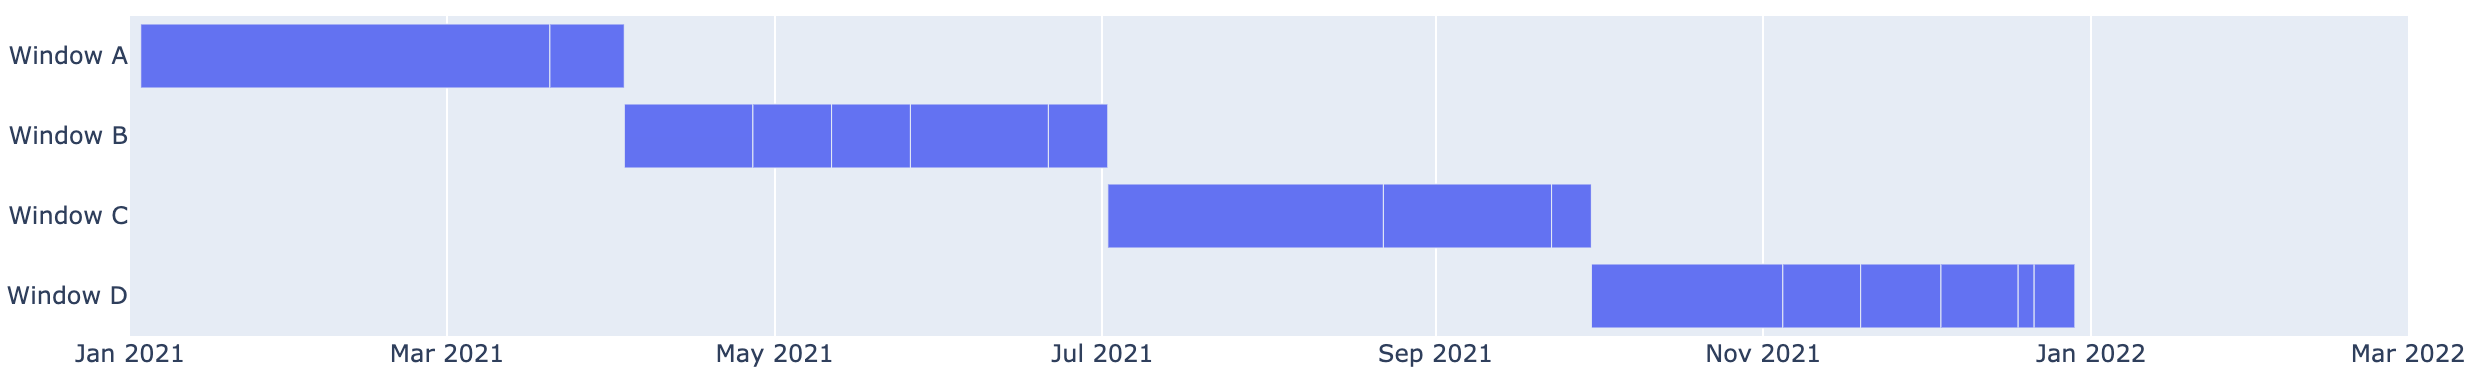

# Sliding time windows

Maybe we want a fixed-sized window, but we don't want to wait until a window finishes so we can start the new one.
We might want to calculate a moving average.

For example, lets say we want to analyze our data for the last three months, but we want to have a monthly report.
In other words, we want windows at a monthly frequency, but each window should cover the last three months.

[`Sliding windows`](https://beam.apache.org/releases/pydoc/current/apache_beam.transforms.window.html#apache_beam.transforms.window.SlidingWindows)
allow us to do just that.
We need to specify the _window size_ in seconds just like with `FixedWindows`. We also need to specify a _window period_ in seconds, which is how often we want to emit each window.

In [12]:
import apache_beam as beam
from datetime import timedelta

# Sliding windows of approximately 3 months every month.
window_size = timedelta(days=3*30).total_seconds()  # in seconds
window_period = timedelta(days=30).total_seconds()  # in seconds
print(f'window_size:   {window_size} seconds')
print(f'window_period: {window_period} seconds')

with beam.Pipeline() as pipeline:
  (
      pipeline
      | 'Astronomical events' >> AstronomicalEvents()
      | 'Sliding windows' >> beam.WindowInto(
          beam.window.SlidingWindows(window_size, window_period)
      )
      | 'Print element info' >> beam.ParDo(PrintElementInfo())
      | 'Print window info' >> PrintWindowInfo()
  )

window_size:   7776000.0 seconds
window_period: 2592000.0 seconds
[2021-03-04 00:00:00 - 2021-06-02 00:00:00] 2021-03-20 03:37:00 -- March Equinox 2021
[2021-02-02 00:00:00 - 2021-05-03 00:00:00] 2021-03-20 03:37:00 -- March Equinox 2021
[2021-01-03 00:00:00 - 2021-04-03 00:00:00] 2021-03-20 03:37:00 -- March Equinox 2021
[2021-04-03 00:00:00 - 2021-07-02 00:00:00] 2021-04-26 22:31:00 -- Super full moon
[2021-03-04 00:00:00 - 2021-06-02 00:00:00] 2021-04-26 22:31:00 -- Super full moon
[2021-02-02 00:00:00 - 2021-05-03 00:00:00] 2021-04-26 22:31:00 -- Super full moon
[2021-05-03 00:00:00 - 2021-08-01 00:00:00] 2021-05-11 13:59:00 -- Micro new moon
[2021-04-03 00:00:00 - 2021-07-02 00:00:00] 2021-05-11 13:59:00 -- Micro new moon
[2021-03-04 00:00:00 - 2021-06-02 00:00:00] 2021-05-11 13:59:00 -- Micro new moon
[2021-05-03 00:00:00 - 2021-08-01 00:00:00] 2021-05-26 06:13:00 -- Super full moon, total lunar eclipse
[2021-04-03 00:00:00 - 2021-07-02 00:00:00] 2021-05-26 06:13:00 -- Super full

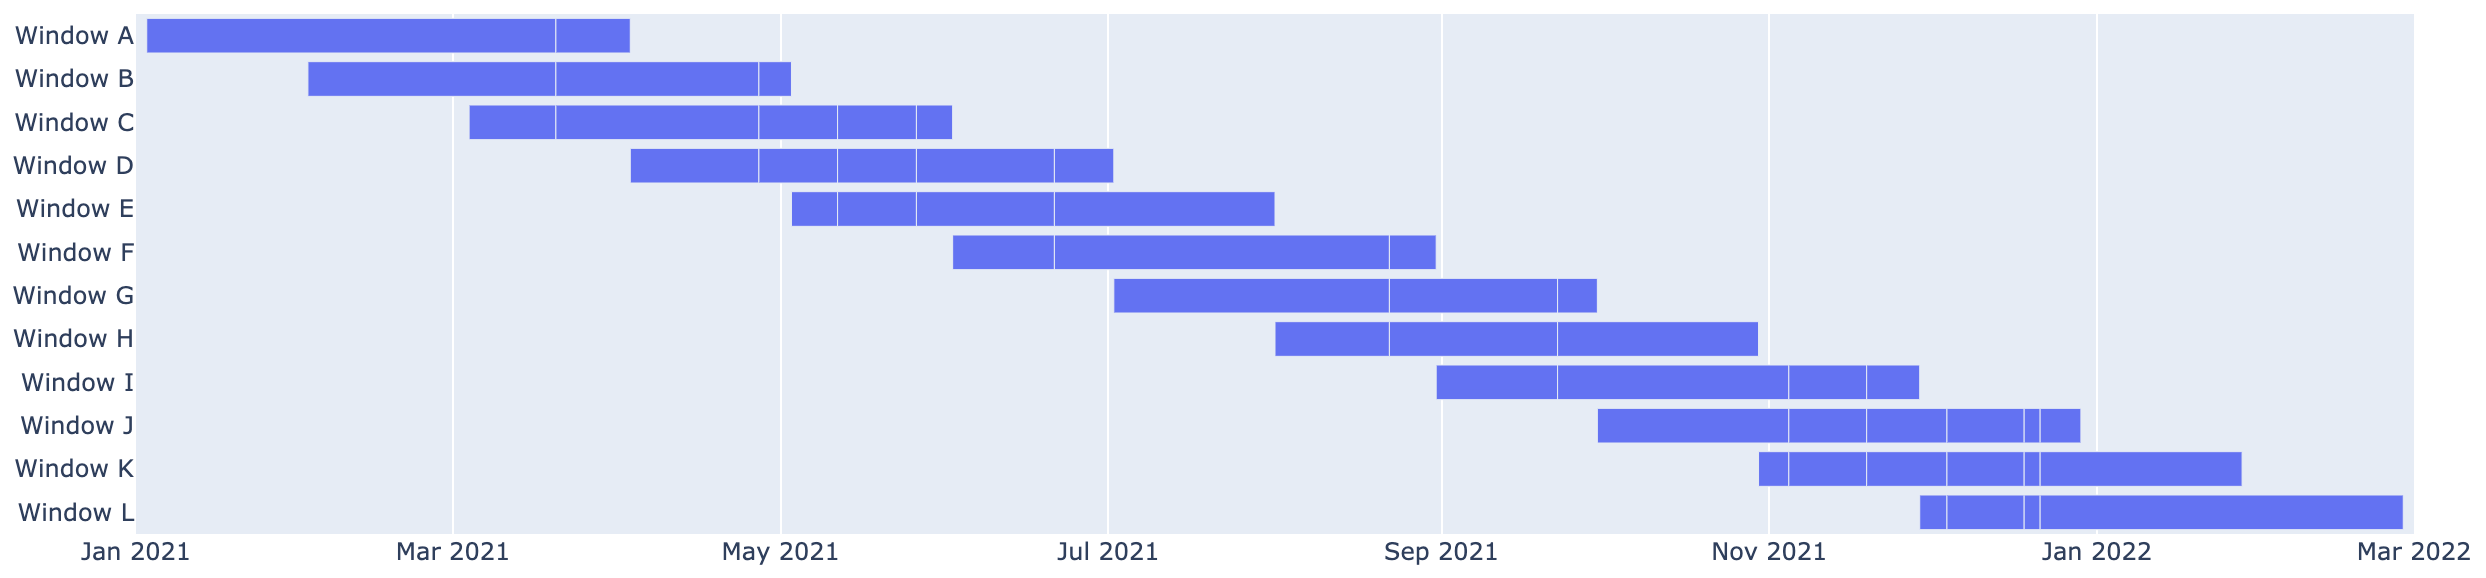

A thing to note with `SlidingWindows` is that one element might be processed multiple times because it might overlap in more than one window.

In our example, the _"processing"_ is done by `PrintElementInfo` which simply prints the element with its window information. For windows of three months every month, each element is processed three times, one time per window.

In many cases, if we're just doing simple element-wise operations, this isn't generally an issue.
But for more resource-intensive transformations, it might be a good idea to perform those transformations _before_ doing the windowing.

In [17]:
import apache_beam as beam
from datetime import timedelta

# Sliding windows of approximately 3 months every month.
window_size = timedelta(days=3*30).total_seconds()  # in seconds
window_period = timedelta(days=30).total_seconds()  # in seconds
print(f'window_size:   {window_size} seconds')
print(f'window_period: {window_period} seconds')

with beam.Pipeline() as pipeline:
  (
      pipeline
      | 'Astronomical events' >> AstronomicalEvents()
      #------
      # ℹ️ Here we're processing / printing the data before windowing.
      | 'Print element info' >> beam.ParDo(PrintElementInfo())
      | 'Sliding windows' >> beam.WindowInto(
          beam.window.SlidingWindows(window_size, window_period)
      )
      #------
      | 'Print window info' >> PrintWindowInfo()
  )

window_size:   7776000.0 seconds
window_period: 2592000.0 seconds
[GlobalWindow] 2021-03-20 03:37:00 -- March Equinox 2021
[GlobalWindow] 2021-04-26 22:31:00 -- Super full moon
[GlobalWindow] 2021-05-11 13:59:00 -- Micro new moon
[GlobalWindow] 2021-05-26 06:13:00 -- Super full moon, total lunar eclipse
[GlobalWindow] 2021-06-20 22:32:00 -- June Solstice 2021
[GlobalWindow] 2021-08-22 07:01:00 -- Blue moon
[GlobalWindow] 2021-09-22 14:21:00 -- September Equinox 2021
[GlobalWindow] 2021-12-21 09:59:00 -- December Solstice 2021
[GlobalWindow] 2021-11-04 15:14:00 -- Super new moon
[GlobalWindow] 2021-11-19 02:57:00 -- Micro full moon, partial lunar eclipse
[GlobalWindow] 2021-12-04 01:43:00 -- Super new moon
[GlobalWindow] 2021-12-18 10:35:00 -- Micro full moon
>> Window [2021-03-04 00:00:00 - 2021-06-02 00:00:00] has 4 elements
>> Window [2021-02-02 00:00:00 - 2021-05-03 00:00:00] has 2 elements
>> Window [2021-01-03 00:00:00 - 2021-04-03 00:00:00] has 1 elements
>> Window [2021-04-03 00

Note that by doing the windowing _after_ the processing, we only process / print the elments once, but the windowing afterwards is the same.

# Session windows

Maybe we don't want regular windows, but instead, have the windows reflect periods where activity happened.

[`Sessions`](https://beam.apache.org/releases/pydoc/current/apache_beam.transforms.window.html#apache_beam.transforms.window.Sessions)
allow us to create those kinds of windows.
We now have to specify a _gap size_ in seconds, which is the maximum number of seconds of inactivity to close a session window.

For example, if we specify a gap size of 30 days. The first event would open a new session window since there are no already opened windows. If the next event happens within the next 30 days or less, like 20 days after the previous event, the session window extends and covers that as well. If there are no new events for the next 30 days, the session window closes and is emitted.

In [19]:
import apache_beam as beam
from datetime import timedelta

# Sessions divided by approximately 1 month gaps.
gap_size = timedelta(days=30).total_seconds()  # in seconds
print(f'gap_size: {gap_size} seconds')

with beam.Pipeline() as pipeline:
  (
      pipeline
      | 'Astronomical events' >> AstronomicalEvents()
      | 'Session windows' >> beam.WindowInto(beam.window.Sessions(gap_size))
      | 'Print element info' >> beam.ParDo(PrintElementInfo())
      | 'Print window info' >> PrintWindowInfo()
  )

gap_size: 2592000.0 seconds
[2021-03-20 03:37:00 - 2021-04-19 03:37:00] 2021-03-20 03:37:00 -- March Equinox 2021
[2021-04-26 22:31:00 - 2021-05-26 22:31:00] 2021-04-26 22:31:00 -- Super full moon
[2021-05-11 13:59:00 - 2021-06-10 13:59:00] 2021-05-11 13:59:00 -- Micro new moon
[2021-05-26 06:13:00 - 2021-06-25 06:13:00] 2021-05-26 06:13:00 -- Super full moon, total lunar eclipse
[2021-06-20 22:32:00 - 2021-07-20 22:32:00] 2021-06-20 22:32:00 -- June Solstice 2021
[2021-08-22 07:01:00 - 2021-09-21 07:01:00] 2021-08-22 07:01:00 -- Blue moon
[2021-09-22 14:21:00 - 2021-10-22 14:21:00] 2021-09-22 14:21:00 -- September Equinox 2021
[2021-12-21 09:59:00 - 2022-01-20 09:59:00] 2021-12-21 09:59:00 -- December Solstice 2021
[2021-11-04 15:14:00 - 2021-12-04 15:14:00] 2021-11-04 15:14:00 -- Super new moon
[2021-11-19 02:57:00 - 2021-12-19 02:57:00] 2021-11-19 02:57:00 -- Micro full moon, partial lunar eclipse
[2021-12-04 01:43:00 - 2022-01-03 01:43:00] 2021-12-04 01:43:00 -- Super new moon
[202

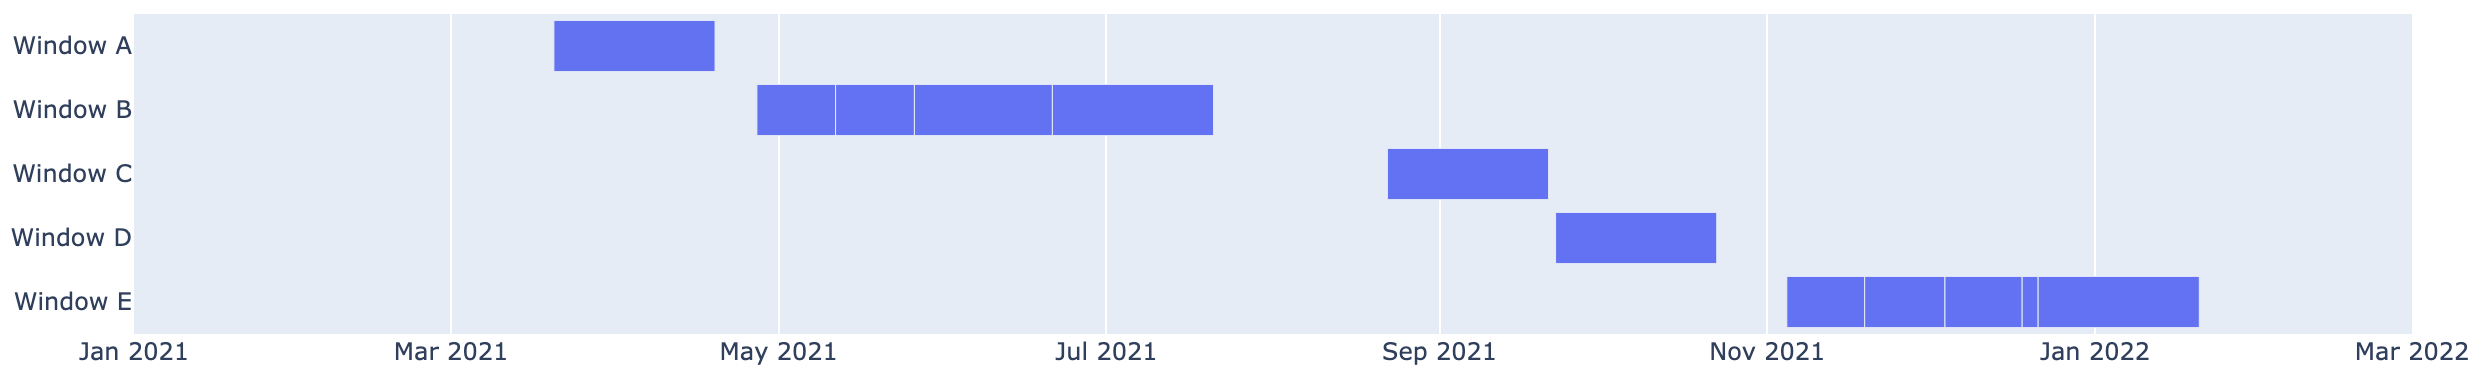

# What's next?

* [Windowing](https://beam.apache.org/documentation/programming-guide/#windowing) -- learn more about windowing in the Beam Programming Guide.
* [Triggers](https://beam.apache.org/documentation/programming-guide/#triggers) -- learn about triggers in the Beam Programming Guide.
* [Transform catalog](https://beam.apache.org/documentation/transforms/python/overview) --
  check out all the available transforms.
* [Mobile gaming example](https://beam.apache.org/get-started/mobile-gaming-example) --
  learn more about windowing, triggers, and streaming through a complete example pipeline.
* [Runners](https://beam.apache.org/documentation/runners/capability-matrix) --
  check the available runners, their capabilities, and how to run your pipeline in them.